In [1]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from time import ctime
from math import sqrt
from math import log
from math import exp
from scipy.stats import norm
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [2]:
# fit function: exponential function with constant background
def fitfunc(x,a,b,c):
    return a*np.exp(-x/b) + c

# fit for a guass
def fitgaus(x,a,b,c):
    return a*np.exp(-(x-b)**2/(2*c**2))
def loglikelihood(par):
    #calculates the contribution to the log likelihood from each point individually
    #negative because computers prefer minimizing
    ll = 0.
    for i,t in enumerate(x):
        mu  = fitfunc(t,par[0],par[1],par[2])
        ll += mu-y[i]*log(mu)
    return 2.*ll   

In [3]:
# LOAD DATA
def LoadAndFilter(filename):
    arr = np.loadtxt(filename)
    raw_dt     = arr[:,0]
    raw_t_abs  = arr[:,1]

# convert absolute times to something human readable
    times = [ctime(t) for t in raw_t_abs]

# select muon events
    muon_dt = raw_dt[raw_dt<40000]                 #filters out failed timings
    muon_dt_micros = [t/1000. for t in muon_dt]    #converts to us
    return(muon_dt_micros)

In [4]:
#Histogram the now filtered data
def Histogramify(muon_dt_micros,bins,filter1,filter2):
    muon_dt_micros=np.array(muon_dt_micros)
    muon_dt_micros = muon_dt_micros[muon_dt_micros>filter1] 
    muon_dt_micros = muon_dt_micros[muon_dt_micros<filter2] 
    plt.figure(1)
    bin_num1 = bins
    n, bins, patches = plt.hist(muon_dt_micros, bin_num1, histtype='stepfilled')
    plt.close(1)
    #calculates bin centers from bin edges
    bincenters = [t+(bins[1]-bins[0])/2. for t in bins]
    #calculates converts the positions, heights and errors into arrays 
    x = np.asarray(bincenters[0:len(n)])
    y = n
    ey = [sqrt(z) for z in y]
    weights = []
    #Sets the correct weights, avoiding div0 errors
    for s in ey:
        if s > 0:
            weights.append(1./(s))
        else:
            weights.append(0.)
    return(x,y,ey,weights)

In [11]:
#function to fit our data
def FitChi(x,y,ey,weights):
# Some vaguely reasonable initial guesses
    temp = np.array(y)
    start_values = [max(y),np.average(x,weights=y),min(temp[temp>0])]




    # Standard chi^2 fit to dat
    parnames = ['scale','decay time','background']
    parunits = ["counts/1 $\\mu$s","$\\mu$s","counts/1 $\\mu$s"]
    #returns the fitted parameters and covariance matrix for a gaussian fit
    p_opt, p_cov = curve_fit(fitfunc,x,y,start_values)
    #produces a nice output of all the relevant fit variables
    print('\n\n====== STANDARD CHISQUARED FIT ======\n')
    chi_squared = 0.
    #calculates the contribution to the chi-squared from each point individually.
    for i, (ix,iy,iey) in enumerate(zip(x,y,ey)):
        if iy > 0:
            chi_squared += ((fitfunc(ix, *p_opt)-iy)/iey)**2
    #use dof to find reduced chi squared
    ndf =  len(x)-len(p_opt)
    reduced_chi_squared = chi_squared/ndf
    #use scipy probability function to find the probability
    prob = chi2.sf(chi_squared,ndf)
    print('The degrees of freedom for this test is',ndf)
    print('The chi squared value is: ',("%.2f" %chi_squared))
    print('The reduced chi squared value is: ',("%.2f" %reduced_chi_squared))
    print('The probability is : ', ("%5.2f" % prob))
    #calculates the errors on the fitted parameters using the covariance matrix
    errors = np.sqrt(np.diag(p_cov))
    for i,(value,error) in enumerate(zip(p_opt,errors)):
        print(("%10s"%parnames[i]),': ',("%.3f"%value),' +/- ',("%.3f"%error),("%s"%parunits[i]))
    
    # Poisson based log-likelihood fit
    # (see handout 'Statistical analysis of data')
    # assumes array x contains the values of bin centers, 
    # assumes. array y contains the values of bin contents
    #minimize the log likelihood (equivalent to maximizing poisson probability)
    res=minimize(loglikelihood,start_values)
    #makes a pretty plot
    return()

In [12]:
def FitPoisson(x,y,ey,weights):
    parnames = ['scale','decay time','background']
    parunits = ["counts/1 $\\mu$s","$\\mu$s","counts/1 $\\mu$s"]
    temp = np.array(y)
    start_values = [max(y),np.average(x,weights=y),min(temp[temp>0])]
    res=minimize(loglikelihood,start_values)
    return(res.x[1],res.x[0])

140
2.048449069049386
0.0043057674314929285


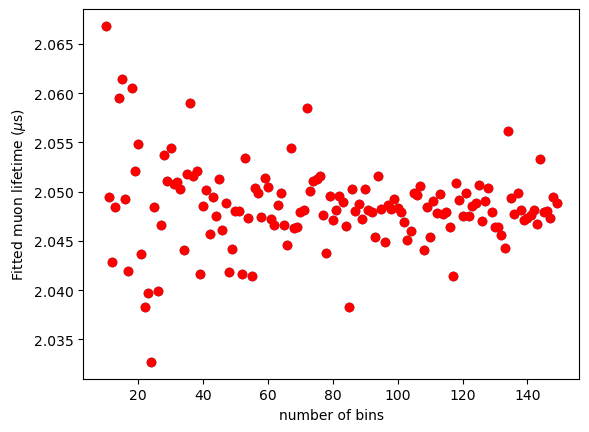

In [41]:
muon_dt_micros=LoadAndFilter("6 day data collection run.data")
lifetimes=[]
bins=np.arange(10,150,1)
for binnum in bins:
    x,y,ey,weights=Histogramify(muon_dt_micros,binnum,0.2,19)
    lifetime=FitPoisson(x,y,ey,weights)
    lifetimes.append(lifetime)
print(len(lifetimes))
print(np.mean(lifetimes))
print(np.std(lifetimes))
plt.scatter(bins,lifetimes)
plt.scatter(bins,lifetimes,color="red")
plt.xlabel("number of bins")
plt.ylabel("Fitted muon lifetime ($\\mu$s)")
plt.show()

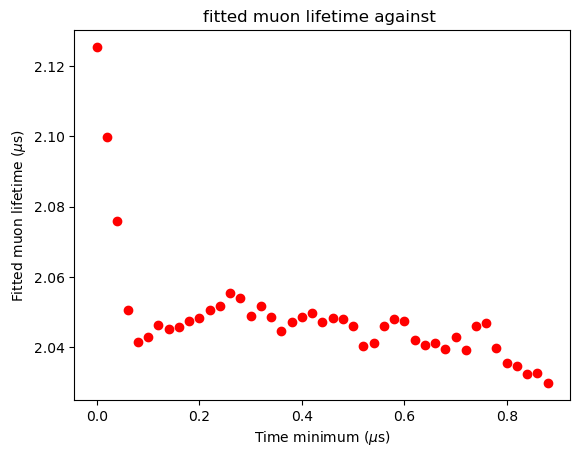

45
2.0436019031967616
0.005234179580006583


In [42]:
muon_dt_micros=LoadAndFilter("6 day data collection run.data")
minimums=np.arange(0,0.9,0.02)
lifetimes=[]
for minfilt in minimums:
    x,y,ey,weights=Histogramify(muon_dt_micros,100,minfilt,19)
    lifetime=FitPoisson(x,y,ey,weights)
    lifetimes.append(lifetime)
plt.scatter(minimums,lifetimes,color="red")
plt.title("fitted muon lifetime against ")
plt.xlabel("Time minimum ($\\mu$s)")
plt.ylabel("Fitted muon lifetime ($\\mu$s)")
plt.show()
print(len(lifetimes))
print(np.mean(lifetimes[15:-1]))
print(np.std(lifetimes[15:-1]))

2.0507925524477315
0.004031258160157748


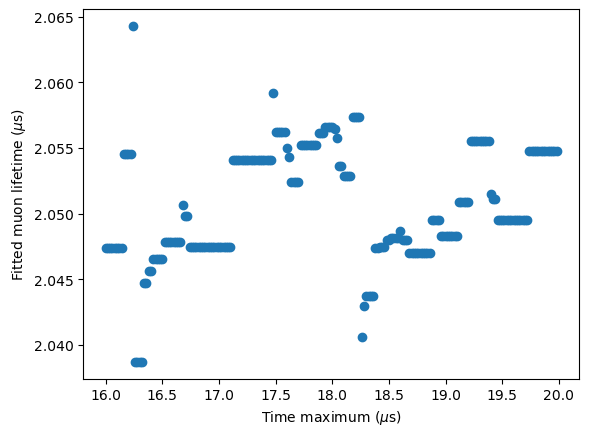

In [43]:
muon_dt_micros=LoadAndFilter("6 day data collection run.data")
maximums=np.arange(16,20,0.02)
lifetimes=[]
for maxfilt in maximums:
    x,y,ey,weights=Histogramify(muon_dt_micros,100,0.2,maxfilt)
    lifetime=FitPoisson(x,y,ey,weights)
    lifetimes.append(lifetime)
plt.scatter(maximums,lifetimes)
plt.xlabel("Time maximum ($\\mu$s)")
plt.ylabel("Fitted muon lifetime ($\\mu$s)")
print(np.mean(lifetimes[15:-1]))
print(np.std(lifetimes[15:-1]))

In [ ]:
muon_dt_micros=LoadAndFilter("28th Oct - 4th Nov data collection run.data")
lifetimes=[]
bins=np.arange(10,200,1)
minimums=np.arange(0.1,1,0.025)
print(minimums)
maximums=np.arange(16.5,20,0.1)
lifetimes=[]
for maxfilt in maximums:
    row=[]
    for minfilt in minimums:
        x,y,ey,weights=Histogramify(muon_dt_micros,130,minfilt,maxfilt)
        try:
            lifetime=FitPoisson(x,y,ey,weights)
        except:
            lifetime=2.06
        row.append(lifetime)
    lifetimes.append(row)
        

18.0154


Text(0.5, 0, 'time ($\\mu$s)')

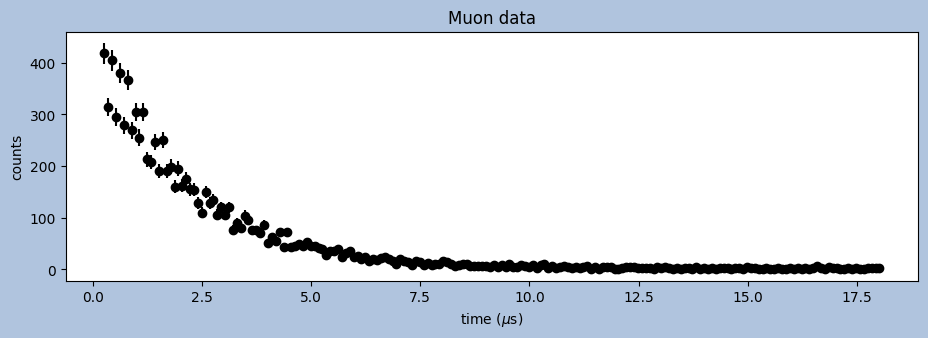

In [50]:
x,y,ey,weights=Histogramify(muon_dt_micros,200,0.2,18.2)
plt.figure(figsize = (11,11), facecolor = 'LightSteelBlue', )
ax = plt.subplot(311)

# Plot data
plt.errorbar(x,y,ey,c='black',fmt='o',label='data')
print(max(x))
plt.title("Muon data")    
plt.ylabel('counts')
plt.xlabel('time ($\mu$s)')    
#plt.plot(x,fitfunc(x,*res.x),'b--', linewidth=2,label='Poisson loglikelihood fit')
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles, labels)
#lifetime=FitPoisson(x,y,ey,weights)
#print(lifetime)

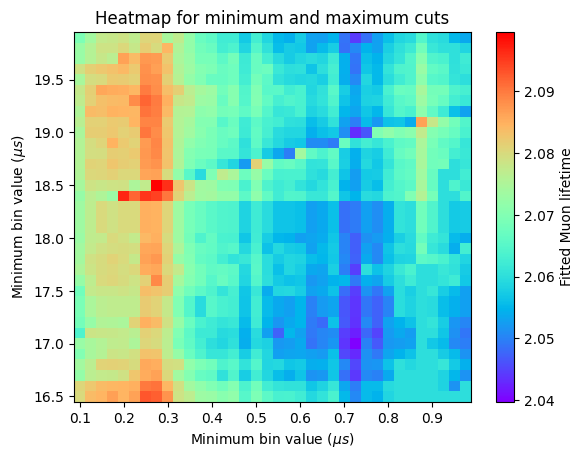

36


In [16]:
plt.pcolormesh( minimums,maximums, lifetimes, cmap='rainbow', shading='auto')
plt.colorbar(label='Fitted Muon lifetime')
plt.xlabel('Minimum bin value ($\mu s$)')
plt.ylabel('Minimum bin value ($\mu s$)')
plt.title('Heatmap for minimum and maximum cuts')
plt.show()
print(len(lifetimes[0]))
y=np.outer(minimums, np.ones(len(minimums)))
x=np.outer(maximums, np.ones(len(maximums)))
lifetimes=np.array(lifetimes)

